In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt # plt 用于显示图片

In [2]:
#unprocess

def random_ccm():
  """Generates random RGB -> Camera color correction matrices."""
  # Takes a random convex combination of XYZ -> Camera CCMs.
  xyz2cams = [[[1.0234, -0.2969, -0.2266],
               [-0.5625, 1.6328, -0.0469],
               [-0.0703, 0.2188, 0.6406]],
              [[0.4913, -0.0541, -0.0202],
               [-0.613, 1.3513, 0.2906],
               [-0.1564, 0.2151, 0.7183]],
              [[0.838, -0.263, -0.0639],
               [-0.2887, 1.0725, 0.2496],
               [-0.0627, 0.1427, 0.5438]],
              [[0.6596, -0.2079, -0.0562],
               [-0.4782, 1.3016, 0.1933],
               [-0.097, 0.1581, 0.5181]]]
  num_ccms = len(xyz2cams) #4
  xyz2cams = tf.constant(xyz2cams) #定义常量
  weights = tf.random.uniform((num_ccms, 1, 1), 1e-8, 1e8)
  weights_sum = tf.reduce_sum(weights, axis=0)
  xyz2cam = tf.reduce_sum(xyz2cams * weights, axis=0) / weights_sum

  # Multiplies with RGB -> XYZ to get RGB -> Camera CCM.
  rgb2xyz = tf.cast([[0.4124564, 0.3575761, 0.1804375],
                         [0.2126729, 0.7151522, 0.0721750],
                         [0.0193339, 0.1191920, 0.9503041]], dtype=tf.float32)
  rgb2cam = tf.matmul(xyz2cam, rgb2xyz)#矩阵相乘

  # Normalizes each row.
  rgb2cam = rgb2cam / tf.reduce_sum(rgb2cam, axis=-1, keepdims=True)
  return rgb2cam


def random_gains():
  """Generates random gains for brightening and white balance."""
  # RGB gain represents brightening.
  rgb_gain = 1.0 / tf.random.normal((), mean=0.8, stddev=0.1)

  # Red and blue gains represent white balance.
  red_gain = tf.random.uniform((), 1.9, 2.4)
  blue_gain = tf.random.uniform((), 1.5, 1.9)
  return rgb_gain, red_gain, blue_gain


def inverse_smoothstep(image):
  """Approximately inverts a global tone mapping curve."""
  image = tf.clip_by_value(image, 0.0, 1.0)#数据收缩到（0，1），（貌似没必要o(*^▽^*)┛
  return 0.5 - tf.sin(tf.asin(1.0 - 2.0 * image) / 3.0)#一通操作下来，还是（0-1）区间，


def gamma_expansion(image):
  """Converts from gamma to linear space."""
  # Clamps to prevent numerical instability of gradients near zero.
  return tf.maximum(image, 1e-8) ** 2.2


def apply_ccm(image, ccm):
  """Applies a color correction matrix."""
  shape = tf.shape(image)
  image = tf.reshape(image, [-1, 3])
  image = tf.tensordot(image, ccm, axes=[[-1], [-1]])
  return tf.reshape(image, shape)


def safe_invert_gains(image, rgb_gain, red_gain, blue_gain):
  """Inverts gains while safely handling saturated pixels."""
  gains = tf.stack([1.0 / red_gain, 1.0, 1.0 / blue_gain]) / rgb_gain
  gains = gains[tf.newaxis, tf.newaxis, :]

  # Prevents dimming of saturated pixels by smoothly masking gains near white.
  gray = tf.reduce_mean(image, axis=-1, keepdims=True)
  inflection = 0.9
  mask = (tf.maximum(gray - inflection, 0.0) / (1.0 - inflection)) ** 2.0
  safe_gains = tf.maximum(mask + (1.0 - mask) * gains, gains)
  return image * safe_gains


def mosaic(image):
  """Extracts RGGB Bayer planes from an RGB image."""
  image.shape.assert_is_compatible_with((None, None, 3))
  shape = tf.shape(image)
  red = image[0::2, 0::2, 0]
  green_red = image[0::2, 1::2, 1]
  green_blue = image[1::2, 0::2, 1]
  blue = image[1::2, 1::2, 2]
  image = tf.stack((red, green_red, green_blue, blue), axis=-1)
  image = tf.reshape(image, (shape[0] // 2, shape[1] // 2, 4))
  return image


def unprocess(image):
  """Unprocesses an image from sRGB to realistic raw data."""
  with tf.name_scope( 'unprocess'):
    image.shape.assert_is_compatible_with([None, None, 3])

    # Randomly creates image metadata.
    rgb2cam = random_ccm()#一个归一化3*3随机矩阵
    cam2rgb = tf.linalg.inv(rgb2cam)#矩阵的逆
    rgb_gain, red_gain, blue_gain = random_gains()#三个随机数
    
    plt.imshow(image) # 显示图片
    plt.show()
    # Approximately inverts global tone mapping.
    image = inverse_smoothstep(image)
    plt.imshow(image) # 显示图片
    plt.show()
    # Inverts gamma compression.
    image = gamma_expansion(image) #固定2.2的高斯
    plt.imshow(image) # 显示图片
    plt.show()
    # Inverts color correction.
    image = apply_ccm(image, rgb2cam)
    plt.imshow(image) # 显示图片
    plt.show()
    # Approximately inverts white balance and brightening.
    image = safe_invert_gains(image, rgb_gain, red_gain, blue_gain)
    plt.imshow(image) # 显示图片
    plt.show()
    # Clips saturated pixels.
    image = tf.clip_by_value(image, 0.0, 1.0)
    # Applies a Bayer mosaic.
    image = mosaic(image)

    metadata = {
        'cam2rgb': cam2rgb,
        'rgb_gain': rgb_gain,
        'red_gain': red_gain,
        'blue_gain': blue_gain,
    }
    return image, metadata


def random_noise_levels():
  """Generates random noise levels from a log-log linear distribution."""
  log_min_shot_noise = tf.math.log(0.0001)
  log_max_shot_noise = tf.math.log(0.012)
  log_shot_noise = tf.random.uniform((), log_min_shot_noise, log_max_shot_noise)
  shot_noise = tf.exp(log_shot_noise)

  line = lambda x: 2.18 * x + 1.20
  log_read_noise = line(log_shot_noise) + tf.random.normal((), stddev=0.26)
  read_noise = tf.exp(log_read_noise)
  return shot_noise, read_noise


def add_noise(image, shot_noise=0.01, read_noise=0.0005):
  """Adds random shot (proportional to image) and read (independent) noise."""
  variance = image * shot_noise + read_noise
  noise = tf.random.normal(tf.shape(image), stddev=tf.sqrt(variance))
  return image + noise

In [3]:
def read_jpg(filename):
  """Reads an 8-bit JPG file from disk and normalizes to [0, 1]."""
  image_file = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image_file, channels=3)
  white_level = 255.0
  return tf.cast(image, tf.float32) / white_level
def is_large_enough(image, height, width):
  """Checks if `image` is at least as large as `height` by `width`."""
  image.shape.assert_has_rank(3)
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  return tf.logical_and(
      tf.greater_equal(image_height, height),
      tf.greater_equal(image_width, width))
def augment(image, height, width):
  """Randomly flips and crops `images` to `height` by `width`."""
  size = [height, width, tf.shape(image)[-1]]
  image = tf.random_crop(image, size)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  return image

def create_example(image):
  """Creates training example of inputs and labels from `image`."""
  image.shape.assert_is_compatible_with([None, None, 3])# 判断是不是(，，3)形状
  image, metadata = unprocess(image)#png 反ISP操作，生成RGGB的RAW图
  shot_noise, read_noise = random_noise_levels()
  noisy_img = add_noise(image, shot_noise, read_noise)
  # Approximation of variance is calculated using noisy image (rather than clean
  # image), since that is what will be avaiable during evaluation.
  variance = shot_noise * noisy_img + read_noise

  inputs = {
      'noisy_img': noisy_img,
      'variance': variance,
  }
  inputs.update(metadata)
  labels = image
  return inputs, labels


2021-12-21 16:45:49.387892: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 16:45:49.389031: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


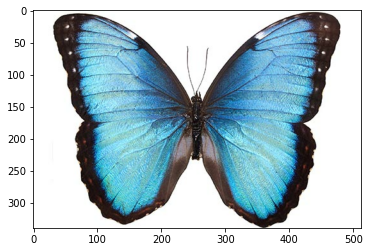

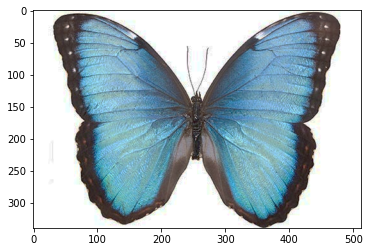

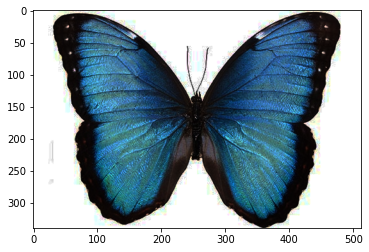

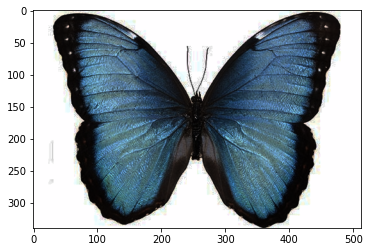

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


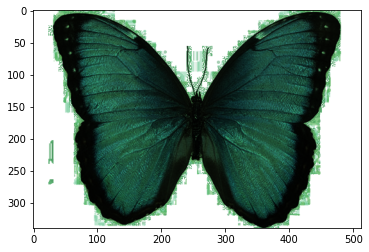

(340, 512, 3)
(170, 256, 4)


In [4]:
file_path = './test_images/btfly.jpg'
tf_img = read_jpg(file_path)


input,groundtruth = create_example(tf_img)
print(tf_img.shape)
print(groundtruth.shape)
# print(input['noisy_img'])
# plt.imshow(tf_img) # 显示图片
plt.show()